# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/gwungwun/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [ ]:
#your code here
data_train = pd.read_csv('data/Bikeshare_train.csv')
data_test = pd.read_csv('data/Bikeshare_test.csv')

In [ ]:
data_train.head()

In [ ]:
# count ~ temp
data_temp = data_train.sort_values('temp')
plt.plot(data_temp.temp, data_temp['count'])
plt.xlabel('Temperature')
plt.ylabel('count')

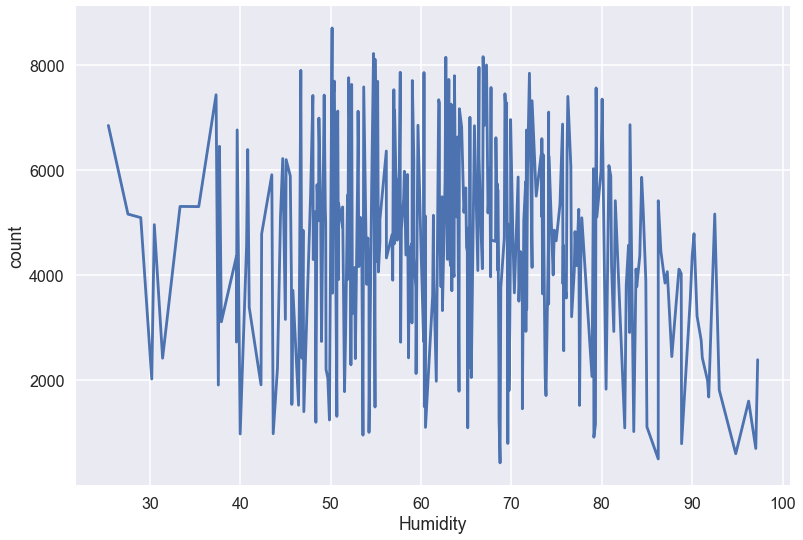

In [6]:
# count ~ humidity
data_tmp = data_train.sort_values('humidity')
plt.plot(data_tmp.humidity, data_tmp['count'])
plt.xlabel('Humidity')
plt.ylabel('count')

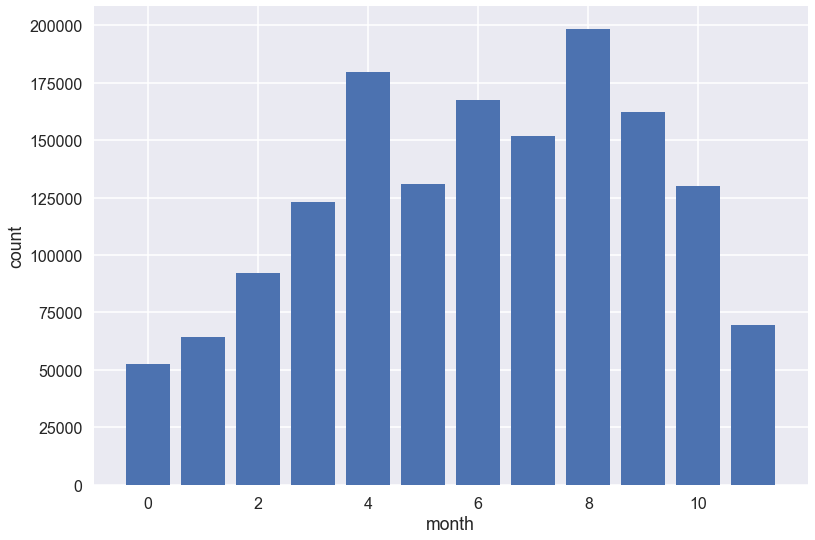

In [7]:
# count ~ month
d = []
for month, subset in data_train.groupby('month'):
    d.append(subset['count'].sum())
    
plt.bar(range(12), d)
plt.xlabel("month")
plt.ylabel("count")

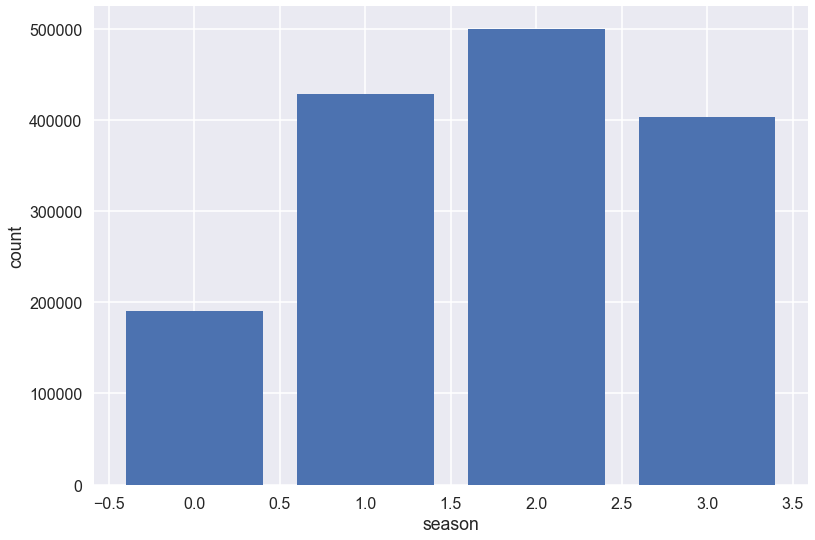

In [8]:
# count ~ month
d = []
for season, subset in data_train.groupby('season'):
    d.append(subset['count'].sum())
    
plt.bar(range(4), d)
plt.xlabel("season")
plt.ylabel("count")

1. Bike rentals has a positive relationship with temperature. This makes intuitive sense since people prefer to ride in good weather (sunny day, summer). However there is a down trend when temperature closes to 30-40 celsius. The reason might be it is too hot to ride. So we may assumer there is a quadratic pattern between counts and temperature.

2. It seems that there is no clear evidence to show bike rentals and humidity has a direct link. Although the count drops a little bit when the humidity approches to the maximum, which may lead to a rain day. Also there are small samples for low humitidy but the sample size is not enought to make a conclusion.

3. Bike rentals are higher in summer than winter. 

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [9]:
categorical_list = ['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather']

x1 = []
x2 = []
for cat in categorical_list:
    x1.append(pd.get_dummies(data_train[cat], drop_first = True).values)
    x2.append(pd.get_dummies(data_test[cat], drop_first = True).values)

In [10]:
# your code here
column_list = ['temp', 'atemp', 'humidity', 'windspeed']
for column in column_list:
    mean = data_train[column].mean()
    sd = data_train[column].std()
    data_train[column] = data_train[column].apply(lambda x: (x - mean) / sd)
    data_test[column] = data_test[column].apply(lambda x: (x - mean) / sd)

In [11]:
data_train.describe()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000
mean,165.000000,2.561934,6.640483,0.033233,2.854985,0.670695,1.389728,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15,4598.447130
std,95.695698,1.094726,3.353974,0.179515,2.048680,0.470672,0.546962,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1935.319338
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,431.000000
25%,82.500000,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,3370.000000
50%,165.000000,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,4648.000000
75%,247.500000,4.000000,9.500000,0.000000,5.000000,1.000000,2.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,5981.000000
max,330.000000,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,8714.000000


In [12]:
data_test.describe()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000
mean,199.500000,2.442500,6.420000,0.02500,3.115000,0.695000,1.400000,-0.128713,-0.121217,-0.076029,-0.008111,4514.21250
std,115.614301,1.122427,3.531966,0.15632,1.962499,0.460984,0.543819,1.052309,1.061183,0.988182,0.983825,2092.60635
min,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,-2.324601,-2.370741,-4.421814,-1.858750,22.00000
25%,99.750000,1.000000,3.000000,0.00000,2.000000,0.000000,1.000000,-1.073765,-1.061707,-0.879771,-0.714163,2875.25000
50%,199.500000,2.000000,6.000000,0.00000,3.000000,1.000000,1.000000,-0.180310,-0.155453,-0.092312,-0.098286,4516.00000
75%,299.250000,3.000000,10.000000,0.00000,5.000000,1.000000,2.000000,0.802489,0.851495,0.665606,0.534842,6174.75000
max,399.000000,4.000000,12.000000,1.00000,6.000000,1.000000,3.000000,1.963980,2.261224,2.202511,4.046877,10045.00000


1. (1)Because categorical attribute is not numeric, they can not be put into computation. 
   (2)Because it can be represented by other columns (in the const term).
  
2. Because we are normalize and train according the training data set. In reality, we never what our test data would look like so we cant't include the mean and SD of test data.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [13]:
x_train = data_train[column_list].values
x_test = data_test[column_list].values

In [14]:
for i in range(len(x1)):
    x_train = np.concatenate((x_train, x1[i]), axis = 1)
    x_test = np.concatenate((x_test, x2[i]), axis = 1)

In [15]:
y_train = data_train['count'].values
y_test = data_test['count'].values

In [16]:
# your code here
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)
results = sm.OLS(y_train, X_train).fit()

In [17]:
y_train_pred = results.predict(X_train)
y_test_pred = results.predict(X_test) 
print('The training R^2 is {}.'.format(r2_score(y_train, y_train_pred)))
print('The testing R^2 is {}.'.format(r2_score(y_test, y_test_pred)))

The training R^2 is 0.5761281783129483.
The testing R^2 is 0.24934211146527585.


In [18]:
results.pvalues

array([  9.36888517e-16,   5.20003187e-02,   4.68024295e-01,
         2.02082679e-06,   1.74423522e-03,   6.63624569e-02,
         6.98974467e-02,   1.61240822e-02,   8.22905821e-01,
         5.92882179e-01,   6.21998562e-01,   9.27860757e-01,
         2.91523211e-01,   1.17803160e-01,   3.29365267e-01,
         5.60204763e-01,   4.56178489e-01,   8.56273925e-01,
         8.14248085e-01,   4.76577152e-01,   4.69763508e-01,
         3.38483767e-01,   4.25745129e-01,   7.66630635e-01,
         5.76936143e-01,   8.49762977e-02,   6.34395986e-02,
         9.37214781e-01,   3.02573366e-03])

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Tue, 03 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        22:09:52   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3681.7765    433.655      8.490      0.000    2828.419    4535.134
x1           925.7338    474.536      1.951      0.052      -8.070    1859.538
x2           312.4341    429.987      0.727      0.468    -533.705    1158.573
x3          -548.4929    113.200     -4.845      0.000    -771.251    -325.735
x4          -255.1226     80.766     -3.159      0.002    -414.057     -96.189
x5           898.8290    487.802      1.843      0.066     -61.079    1858.737
x6          1032.8816    567.827      1.819      0.070     -84.503    2150.266
x7          1226.1865    506.763      2.420      0.016     228.966    2223.407
x8            88.9401    397.048      0.224      0.823    -692.381     870.262
x9           239.1809    446.873      0.535      0.593    -640.188    1118.549
x10          333.3491    675.444      0.494      0.622    -995.806    1662.504
x11          -65.8125    726.311     -0.091      0.928   -1495.065    1363.440
x12         -792.2629    749.803     -1.057      0.292   -2267.744     683.218
x13        -1279.9870    816.047     -1.569      0.118   -2885.824     325.850
x14         -776.4755    794.782     -0.977      0.329   -2340.467     787.516
x15          405.1446    694.714      0.583      0.560    -961.931    1772.220
x16          486.2509    651.713      0.746      0.456    -796.206    1768.708
x17          112.6816    621.610      0.181      0.856   -1110.538    1335.902
x18         -118.8358    505.353     -0.235      0.814   -1113.282     875.611
x19         -284.3563    398.982     -0.713      0.477   -1069.483     500.770
x20         -123.7515    170.981     -0.724      0.470    -460.212     212.709
x21         -195.2859    203.703     -0.959      0.338    -596.137     205.565
x22          170.5113    213.789      0.798      0.426    -250.187     591.210
x23           61.2560    206.213      0.297      0.767    -344.536     467.048
x24          111.0669    198.877      0.558      0.577    -280.288     502.422
x25          465.1450    269.154      1.728      0.085     -64.504     994.794
x26          308.1531    165.413      1.863      0.063     -17.351     633.657
x27          -16.5666    210.139     -0.079      0.937    -430.083     396.949
x28        -1581.9783    529.223     -2.989      0.003   -2623.396    -540.560
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     2.66e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

1. According to the summary, the following estimated coefficients are statistically significant:
humidity, windspeed, season(autumn) and weather(4)

2. Season(autumn) has positive relationship with bike rental. This agrees with our graph in EDA.

3. No. Since their p value of t-stat is greater than 5%.

4. Negative but it is not statistically significant. People might tend to travel rather than drive to commute during holidays.

5. Temp has a greater positive effect on bike rentals than atemp. This is because apprent temperature is a combination of temperature and humidity, windspeed and so on. So higher atemp may lead to uncomfortable in exercising.

In [20]:
e = [y_train[i] - y_train_pred[i] for i in range(len(y_train))]

In [21]:
#y_train_sort, y_train_pred_sort = zip(*sorted(zip(y_train, y_train - y_train_pred)))

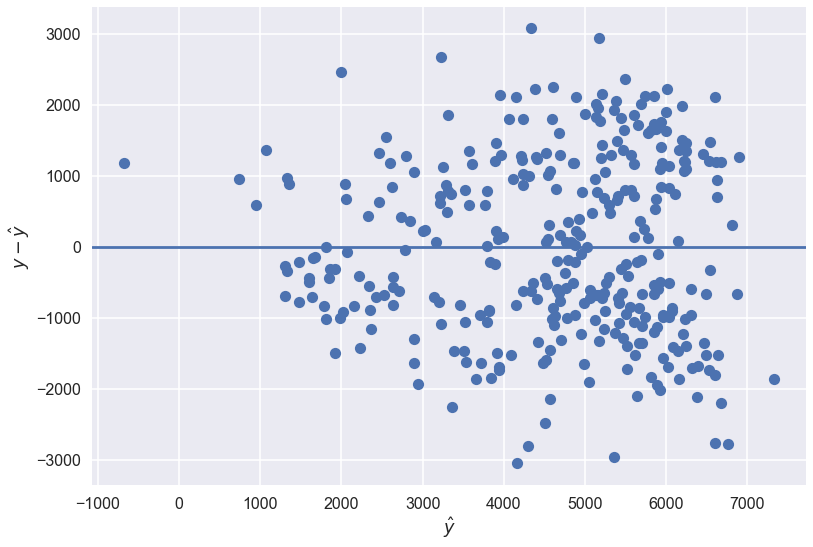

In [23]:
plt.plot(y_train_pred, e,'o')
plt.xlabel('$\hat{y}$')
plt.ylabel('$y - \hat{y}$')
plt.axhline(0)

There is a positive linear relationships between residue and the number of bike rentals. That means if the number of bike rentals is out of the common range, then there will be greater deviation in the prediction.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [25]:
# your code here
corr = np.corrcoef(x_train.transpose())

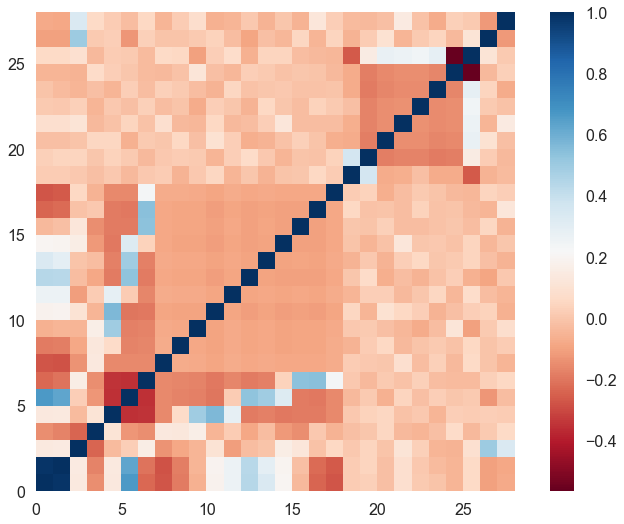

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
cm = ax.pcolor(corr, cmap='RdBu');
plt.colorbar(cm)

1. Temperature and apparent temperature are apparently collinear.

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [23]:
# your code here
#forward
# selected = np.ones([len(x_train),1])
# test_selected = np.ones([len(x_test),1])

# bic = float("inf")
# mark = 0
# for i in range(len(x_train[0])): ## number of predicators
#     for col in categorical_list:
#         tmp = pd.get_dummies(data_train[col], drop_first= True)
#         for j in tmp.columns:
#             testfordummy = tmp.loc[:, j].values
#             testfordummy = testfordummy.reshape(-1, 1)
#             testfordummy = np.concatenate((selected, testfordummy), axis = 1)
#             #X_train_step = sm.add_constant(testfordummy)
#             results = sm.OLS(y_train, X_train_step).fit()
#             if results.bic < bic:
#                 best = testfordummy
#                 test_tmp = pd.get_dummies(data_test[col], drop_first= True)
#                 test_best = np.concatenate((test_selected, test_tmp.loc[:, j].values.reshape(-1, 1)), axis = 1)
#                 best_col = (col, j, r2_score(y_test, results.predict(test_best)))
#                 bic = results.bic
                
#     for l in range(4):
#         testfordummy = np.concatenate((selected, x_train[:, l].reshape(-1,1)), axis = 1)
#         #X_train_step = sm.add_constant(testfordummy)
#         results = sm.OLS(y_train, X_train_step).fit()
#         if results.bic < bic:
#             best = testfordummy
#             test_best = np.concatenate((test_selected, x_test[:, l].reshape(-1,1)), axis = 1)
#             best_col = (column_list[l], r2_score(y_test, results.predict(test_best)))
#             bic = results.bic

#     if mark == bic:
#         break
    
#     print(bic)
#     print(best_col)

#     mark = bic
#     selected = best
#     test_selected = test_best

In [24]:
#forward
bic = float("inf")
mark = 0
total_predictor_number = len(x_train[0])
selected = np.ones([len(x_train),1])
test_selected = np.ones([len(x_test),1])

for i in range(total_predictor_number): ## number of predicators
    for j in range(len(x_train[0])): 
        X_train_forward = np.concatenate((selected, x_train[:, j].reshape(-1, 1)), axis = 1)
        results = sm.OLS(y_train, X_train_forward).fit()
        if results.bic < bic:
            best = X_train_forward
            bic = results.bic
            test_best = np.concatenate((test_selected, x_test[:, j].reshape(-1, 1)), axis = 1)
            best_col = j 
            best_r2 = r2_score(y_test, results.predict(test_best))
    
    if mark == bic:
        break
    
    mark = bic
    x_train = np.concatenate((x_train[:, : best_col], x_train[:, best_col + 1:]), axis = 1)
    x_test = np.concatenate((x_test[:, : best_col], x_test[:, best_col + 1:]), axis = 1)
    selected = best
    test_selected = test_best

In [25]:
print("The testing R^2 for forward selection is {}" .format(best_r2))

The testing R^2 for forward selection is 0.27579228428983527


In [26]:
#backward
bic = float("inf")
mark = 0
total_predictor_number = len(X_train[0])
selected_backward = np.ones([len(X_train),1])
X_train_copy = X_train
X_test_copy = X_test

for i in range(total_predictor_number): ## number of predicators
    for j in range(1, len(X_train[0])): 
        X_train_backward = np.concatenate((X_train[:, : j], X_train[:, j + 1:]), axis = 1)
        results = sm.OLS(y_train, X_train_backward).fit()
        if results.bic < bic:
            best = X_train_backward
            bic = results.bic
            test_best = np.concatenate((X_test[:, : j], X_test[:, j + 1:]), axis = 1)
            best_col = j
            best_r2 = r2_score(y_test, results.predict(test_best))
    
    if mark == bic:
        break
    
    mark = bic
    X_train = np.concatenate((X_train[:, : best_col], X_train[:, best_col + 1:]), axis = 1)
    X_test = np.concatenate((X_test[:, : best_col], X_test[:, best_col + 1:]), axis = 1)
    selected_backward = best
    test_selected_backward = test_best 

In [27]:
print("The testing R^2 for backward selection is {}" .format(best_r2))

The testing R^2 for backward selection is 0.2617647172198442


Yes either temp or atemp would be drop in the selection. Also both of forward and backward stepwise selection has higher r^2 score.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [28]:
# your code here
from sklearn.model_selection import KFold
n_folds=10

train_errors = np.zeros(n_folds)
valid_errors = np.zeros(n_folds)

In [29]:
## all predictors

fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(331)): # split data into train/test groups, 4 times
    est = sm.OLS(y_train[train], X_train_copy[train]).fit()
    train_errors[fold] = r2_score(y_train[train], est.predict(X_train_copy[train])) # evaluate score function on held-out data
    valid_errors[fold] = r2_score(y_train[valid], est.predict(X_train_copy[valid])) # evaluate score function on held-out data
    fold += 1

valid_errors.mean()

0.40939518317318147

In [30]:
est = sm.OLS(y_test, X_test_copy).fit()
print(r2_score(y_test, est.predict(X_test_copy)))

0.357710855043


In [31]:
## forward predictors

fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(331)): # split data into train/test groups, 4 times
    est = sm.OLS(y_train[train], selected[train]).fit()
    train_errors[fold] = r2_score(y_train[train], est.predict(selected[train])) # evaluate score function on held-out data
    valid_errors[fold] = r2_score(y_train[valid], est.predict(selected[valid])) # evaluate score function on held-out data
    fold += 1

valid_errors.mean()

0.48075061720463913

In [32]:
est = sm.OLS(y_test, test_selected).fit()
print(r2_score(y_test, est.predict(test_selected)))

0.312601723929


In [33]:
## backward predictors

fold = 0
for train, valid in KFold(n_folds, shuffle=True).split(range(331)): # split data into train/test groups, 4 times
    est = sm.OLS(y_train[train], selected_backward[train]).fit()
    train_errors[fold] = r2_score(y_train[train], est.predict(selected_backward[train])) # evaluate score function on held-out data
    valid_errors[fold] = r2_score(y_train[valid], est.predict(selected_backward[valid])) # evaluate score function on held-out data
    fold += 1

valid_errors.mean()

0.49450527841331926

In [34]:
est = sm.OLS(y_test, test_selected_backward).fit()
print(r2_score(y_test, est.predict(test_selected_backward)))

0.336871587135


1. Using all predictors to do regression may have overfir. So the R^2 score on training data is relatively higher.

2. Not agree. Since we fit the model on the test data, so it would still have overfit problem. The model with more predictors would behave better.

    Also the results may depend on the random choice of validation set. 

In [ ]:
plt.plot(y_train)